# Measuring pH of tumors using CEST MRI, salycilic acid and machine learning
## By Julio Cárdenas-Rodriguez
![](https://upload.wikimedia.org/wikipedia/commons/thumb/5/5f/Hirnmetastase_MRT-T1_KM.jpg/300px-Hirnmetastase_MRT-T1_KM.jpg)

<h1><center>Why should I care ?</center></h1>
<img src="./images/tumor_pH.png" alt="Drawing" style="width: 600px;"/>

<h1><center>CEST MRI and aspirin</center></h1>
<img src="./images/cest_and_sacid.png" alt="Drawing" style="width: 600px;"/>

<h1><center>CODE</center></h1>
<img src="./images/code.png" alt="Drawing" style="width: 600px;"/>

In [1]:
# Modules by Julio
from qMRI.get_data import load_data
from qMRI.cest import lorentzian_fit, lorentzian_sim, normalize

# boiler plate
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# variables
data_main_dir = '/Users/Julio/Insight-Health-Data-Science/data/'
pH_dirs = ['pH6.02',
           'pH6.25',
           'pH6.60',
           'pH6.77',
           'pH7.03',
           'pH7.19',
           'pH7.40','pH8.00']

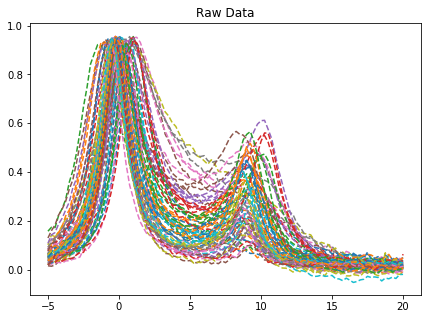

In [9]:
# Get data
Spectra, Conc, pH, ppm = load_data(pH_dirs,data_main_dir);

# Normalize and keep only relevant offsets
Z = 1- normalize(Spectra,3)[4::]
ppm = ppm[4::]

# plot
plt.figure(figsize=(7,5))
plt.plot(ppm,Z,'--'); plt.title('Raw Data')

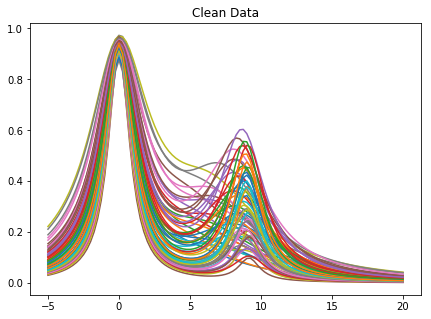

In [10]:
# clean data and center
X_predictors = np.zeros_like(Z.T)
for idx, z_data in enumerate(Z.T):
    xp, zc, = lorentzian_fit(ppm, Z[:,idx], [0,10])
    X_predictors[idx,:] = np.squeeze(lorentzian_sim(ppm,xp[0::3],xp[1::3], xp[2::3] - xp[2]))

plt.figure(figsize=(7,5))
plt.plot(ppm,X_predictors.T); plt.title('Clean Data')

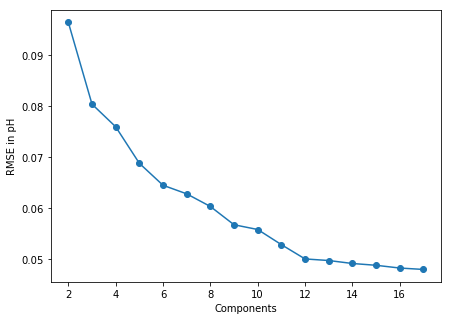

In [17]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error as rmse
comp = np.arange(2,18,1)
error = np.zeros((len(comp),1))

for idx, N in enumerate(comp):
    pls2 = PLSRegression(n_components=N, scale=False, max_iter=500, tol=1e-06, copy=True)
    pls2.fit(X_predictors, pH)
    Y_pred = pls2.predict(X_predictors)
    error[idx] = (rmse(pH,Y_pred))

plt.figure(figsize=(7,5))
plt.plot(comp,error,'o-')
plt.xlabel('Components')
plt.ylabel('RMSE in pH')

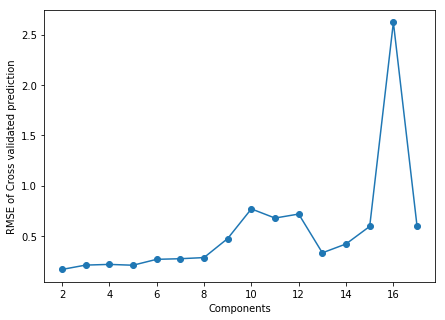

In [19]:
from sklearn.model_selection import cross_val_predict
for idx, N in enumerate(comp):
    pls2 = PLSRegression(n_components=N, scale=False, max_iter=500, tol=1e-06, copy=True)
    scores = cross_val_predict(pls2, X_predictors, pH, cv=5)
    error[idx] =rmse(pH,scores)

plt.figure(figsize=(7,5))
plt.plot(comp,error,'o-')
plt.xlabel('Components')
plt.ylabel('RMSE of Cross validated prediction')